In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread
from collections import Counter
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from data import MovieLensSequenceDataset
from movielens_transformer import (
    MovieLensTransformer,
    MovieLensTransformerConfig,
    TransformerConfig,
)
import torch.nn.functional as F
from dacite import from_dict
import pprint
from model_train import run_model_training, load_config, get_model_config

## Movielens Dataset

Let's start with reading and exploring the dataset

In [2]:
users = pd.read_csv(
    "./data/ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={
        "user_id": np.int32,
        "sex": "category",
        "age_group": "category",
        "occupation": "category",
        "zip_code": str,
    },
)

ratings = pd.read_csv(
    "./data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={
        "user_id": np.int32,
        "movie_id": np.int32,
        "rating": np.int8,
        "unix_timestamp": np.int32,
    },
)

movies = pd.read_csv(
    "./data/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={"movie_id": np.int32, "title": str, "genres": str},
)

In [3]:
users.head()

user_id sex age_group occupation zip_code
0        1   F         1         10    48067
1        2   M        56         16    70072
2        3   M        25         15    55117
3        4   M        45          7    02460
4        5   M        25         20    55455

In [4]:
ratings.head()

user_id  movie_id  rating  unix_timestamp
0        1      1193       5       978300760
1        1       661       3       978302109
2        1       914       3       978301968
3        1      3408       4       978300275
4        1      2355       5       978824291

In [5]:
movies.head()

movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

In a separate csv, we also have links to the movie posters just to add a little bit more flare to the exploration

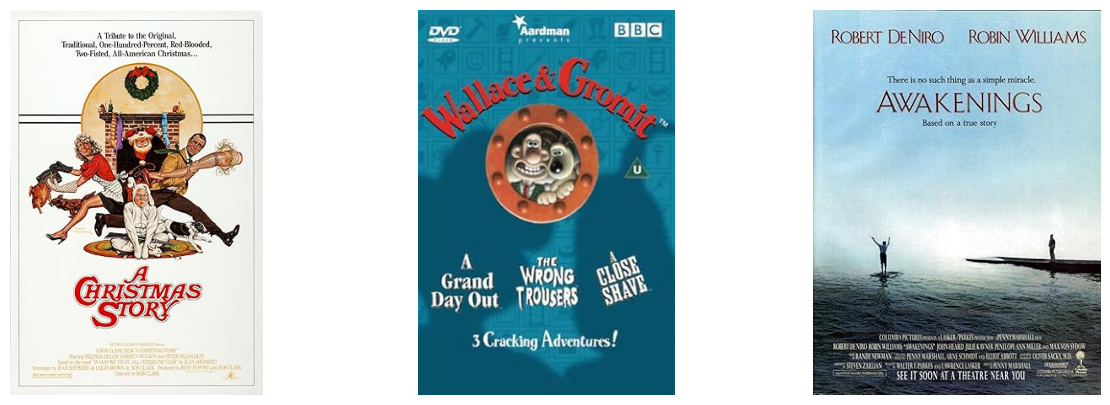

In [6]:
image_urls = pd.read_csv("./data/movie_poster_1m.csv", index_col="item_id")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (ax, img) in enumerate(zip(axs.flat, image_urls.iloc[[7, 10, 17], 0].values)):
    ax.imshow(imread(img))  # Display the image
    ax.axis("off")  # Turn off axis
plt.show()

## Tokenization

Let's now tokenize the user_ids and movie_ids such that both map on to 0:N space, where N is the number of unique entities.

In [7]:
# user ids
unique_user_ids = users["user_id"].unique()
unique_user_ids.sort()

# movie ids
unique_movie_ids = movies["movie_id"].unique()
unique_movie_ids.sort()

# tokenization
user_id_tokens = {user_id: i for i, user_id in enumerate(unique_user_ids)}
movie_id_tokens = {movie_id: i for i, movie_id in enumerate(unique_movie_ids)}

## Sequence Generation

In [8]:
ratings["user_id_tokens"] = ratings["user_id"].map(user_id_tokens)
ratings["movie_id_tokens"] = ratings["movie_id"].map(movie_id_tokens)

In [9]:
ratings_ordered = (
    ratings[["user_id_tokens", "movie_id_tokens", "unix_timestamp", "rating"]]
    .sort_values(by="unix_timestamp")
    .groupby("user_id_tokens")
    .agg(list)
    .reset_index()
)

In [10]:
ratings_ordered

user_id_tokens                                    movie_id_tokens  \
0                  0  [3117, 1672, 1250, 1009, 2271, 1768, 3339, 118...   
1                  1  [1180, 1199, 1192, 2648, 1273, 2874, 1207, 117...   
2                  2  [589, 2789, 3465, 1899, 1892, 1407, 1246, 3602...   
3                  3  [1192, 1081, 476, 3399, 3458, 1178, 257, 1180,...   
4                  4  [2648, 907, 896, 352, 1230, 2119, 2789, 1111, ...   
...              ...                                                ...   
6035            6035  [1672, 1814, 3369, 2307, 2359, 2614, 2503, 263...   
6036            6036  [1813, 693, 1247, 1959, 3439, 3079, 558, 847, ...   
6037            6037  [3327, 908, 1192, 2077, 1366, 352, 1063, 1132,...   
6038            6038  [109, 279, 1998, 1211, 918, 935, 3019, 2953, 3...   
6039            6039  [847, 2315, 589, 1892, 1950, 1395, 211, 3042, ...   

                                         unix_timestamp  \
0     [978300019, 978300055, 978300055, 978300055, 9...   
1     [978298124, 978298151, 978298151, 978298196, 9...   
2     [978297018, 978297039, 978297068, 978297068, 9...   
3     [978293924, 978293964, 978294008, 978294008, 9...   
4     [978241072, 978241072, 978241072, 978241112, 9...   
...                                                 ...   
6035  [956709349, 956709350, 956709350, 956709350, 9...   
6036  [956708997, 956708997, 956708997, 956708997, 9...   
6037  [956706827, 956706827, 956706876, 956706909, 9...   
6038  [956705158, 956705158, 956705178, 956705202, 9...   
6039  [956703932, 956703954, 956703954, 956703977, 9...   

                                                 rating  
0     [4, 4, 5, 5, 3, 5, 4, 4, 5, 4, 3, 5, 4, 4, 4, ...  
1     [4, 3, 4, 3, 5, 4, 5, 5, 5, 4, 4, 2, 5, 4, 4, ...  
2     [3, 4, 3, 4, 4, 3, 5, 5, 4, 5, 4, 5, 4, 4, 4, ...  
3     [3, 4, 4, 5, 1, 2, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...  
4     [1, 4, 4, 1, 5, 1, 4, 1, 2, 3, 5, 4, 4, 3, 5, ...  
...                                                 ...  
6035  [4, 4, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 5, 4, ...  
6036  [1, 2, 5, 4, 3, 4, 4, 5, 5, 4, 3, 4, 3, 4, 5, ...  
6037  [3, 3, 4, 4, 2, 4, 5, 5, 3, 3, 4, 4, 5, 4, 5, ...  
6038  [4, 4, 4, 3, 4, 3, 5, 4, 3, 3, 4, 2, 3, 2, 4, ...  
6039  [4, 4, 5, 4, 5, 3, 5, 5, 4, 4, 2, 5, 5, 5, 5, ...  

[6040 rows x 4 columns]

In [11]:
sequence_length = 5
min_sequence_length = 1
window_size = 1

Let's first generate a sequence for one user_id and make sure we generate the correct sequences. Then we can expand that to all the data.

In [12]:
sample_data = ratings_ordered.iloc[0]
sample_movie_ids = torch.tensor(sample_data.movie_id_tokens, dtype=torch.int32)
sample_ratings = torch.tensor(sample_data.rating, dtype=torch.int8)
sample_movie_sequences = (
    sample_movie_ids.ravel().unfold(0, sequence_length, 1).to(torch.int32)
)
sample_rating_sequences = (
    sample_ratings.ravel().unfold(0, sequence_length, 1).to(torch.int8)
)

In [13]:
sample_movie_sequences

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


In [14]:
sample_rating_sequences

tensor([[4, 4, 5, 5, 3],
        [4, 5, 5, 3, 5],
        [5, 5, 3, 5, 4],
        [5, 3, 5, 4, 4],
        [3, 5, 4, 4, 5],
        [5, 4, 4, 5, 4],
        [4, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 5],
        [4, 4, 4, 5, 5],
        [4, 4, 5, 5, 5],
        [4, 5, 5, 5, 4],
        [5, 5, 5, 4, 5],
        [5, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 3],
        [4, 4, 4, 3, 4],
        [4, 4, 3, 4, 4],
        [4, 3, 4, 4, 4],
        [3, 4, 4, 4, 4],
        [4, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 3],
        [4, 5, 3, 3, 4],
        [5, 3, 3, 4, 4],
        [3, 3, 4, 4, 4],
        [3, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 5],


In [15]:
def generate_sequences(row, sequence_length, window_size):
    movie_ids = torch.tensor(row.movie_id_tokens, dtype=torch.int32)
    ratings = torch.tensor(row.rating, dtype=torch.int8)
    movie_sequences = (
        movie_ids.ravel().unfold(0, sequence_length, window_size).to(torch.int32)
    )
    rating_sequences = (
        ratings.ravel().unfold(0, sequence_length, window_size).to(torch.int8)
    )
    return (movie_sequences, rating_sequences)

In [16]:
for i, row in ratings_ordered.iterrows():
    movie_sequences, rating_sequences = generate_sequences(
        row, sequence_length, window_size
    )
    print(movie_sequences)
    print(rating_sequences)
    break

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


Let us convert all the scrappy code into a proper `Dataset` class. We will call this `MovieLensSequenceDataset`.

In [17]:
dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=5,
    window_size=1,
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
batch = next(iter(dataloader))
for t in batch:
    print(t)
    print(t.shape)
    print("-----------------------------------")

2024-08-21 07:05:35.285 | INFO     | data:__init__:47 - Creating MovieLensSequenceDataset with validation set: %s
2024-08-21 07:05:35.286 | INFO     | data:_read_data:60 - Reading data from files
2024-08-21 07:05:37.019 | INFO     | data:_add_tokens:122 - Adding tokens to data
2024-08-21 07:05:37.055 | INFO     | data:_generate_sequences:132 - Generating sequences
2024-08-21 07:05:37.635 | INFO     | data:__init__:55 - Train data length: 183321
2024-08-21 07:05:37.636 | INFO     | data:__init__:56 - Validation data length: 20375


tensor([[3118, 1673, 1251, 1010, 2272],
        [1769, 3340, 1190, 2736,  258],
        [ 712, 1177,  908,  605, 2624],
        [1893, 1960, 3037,  927, 1023]], dtype=torch.int32)
torch.Size([4, 5])
-----------------------------------
tensor([[4, 4, 5, 5, 3],
        [5, 4, 4, 5, 4],
        [3, 5, 4, 4, 4],
        [5, 5, 5, 4, 5]], dtype=torch.int8)
torch.Size([4, 5])
-----------------------------------
tensor([0, 0, 0, 0], dtype=torch.int32)
torch.Size([4])
-----------------------------------
tensor([[1673, 1251, 1010, 2272, 1769],
        [3340, 1190, 2736,  258,  712],
        [1177,  908,  605, 2624, 1893],
        [1960, 3037,  927, 1023, 1894]], dtype=torch.int32)
torch.Size([4, 5])
-----------------------------------
tensor([[4, 5, 5, 3, 5],
        [4, 4, 5, 4, 3],
        [5, 4, 4, 4, 5],
        [5, 5, 4, 5, 4]], dtype=torch.int8)
torch.Size([4, 5])
-----------------------------------


## Model Definition

Let build the transformer based recommendation model now. We can reuse most of the code that I wrote for my previous post on [Exploring GPT](https://www.kapilsharma.dev/posts/exploring-gpt2/). We will skip defining the `CausalMultiHeadAttention`, `MLP`, `TransformerEncoderLayer` (defined as `GPT2Layer` in previous post), and `Transformer` (defined as `GPT2` in the previous post). Instead, let me just show the differences between what the GPT2 for language model defined vs here.

We will skip the `output_layer` in the `Transformer` i.e. just remove it. We need an interaction layer between the movies and users in rec sys model. Hence, the output layer will be after the interaction. This interaction layer will be defined as an MLP (similar to the one we defined in [DLRM exploration](https://www.kapilsharma.dev/posts/cuda-mode-fusing-kernels-talk/)). 

```python
class InteractionMLP(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int):
        super(InteractionMLP, self).__init__()
        fc_layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                fc_layers.append(nn.Linear(input_size, hidden_size))
            else:
                fc_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))
            fc_layers.append(nn.ReLU())
        fc_layers.append(
            nn.Linear(
                hidden_sizes[-1] if hidden_sizes else input_size,
                output_size,
                bias=False,
            )
        )
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x: torch.Tensor):
        return self.fc_layers(x)

```

### Final Movielens RecSys Model

```python
class MovieLensTransformer(nn.Module):
    def __init__(self, config: MovieLensTransformerConfig):
        super().__init__()
        self.movie_transformer = Transformer(config.movie_transformer_config)
        self.user_embedding = nn.Embedding(
            config.num_users, config.user_embedding_dimension
        )

        self.output_layer = InteractionMLP(
            config.movie_transformer_config.embedding_dimension
            + config.user_embedding_dimension,
            config.interaction_mlp_hidden_sizes,
            config.movie_transformer_config.vocab_size,
        )

    def forward(self, movie_ids: torch.Tensor, user_ids: torch.Tensor):
        movie_embeddings = self.movie_transformer(movie_ids)
        user_embeddings = self.user_embedding(user_ids)
        embeddings = torch.cat([movie_embeddings, user_embeddings], dim=-1)
        return self.output_layer(embeddings)  # returns logits
```


## Testing

Next, let's test the model that we defined to see if we can run a sample batch through it.

In [18]:
movie_ids, ratings, user_ids, output_movie_ids, output_ratings = batch

In [19]:
movie_ids

tensor([[3118, 1673, 1251, 1010, 2272],
        [1769, 3340, 1190, 2736,  258],
        [ 712, 1177,  908,  605, 2624],
        [1893, 1960, 3037,  927, 1023]], dtype=torch.int32)

In [20]:
user_ids

tensor([0, 0, 0, 0], dtype=torch.int32)

In [21]:
config_json = {
    "movie_transformer_config": {
        "vocab_size": len(dataset.metadata.movie_id_tokens),
        "context_window_size": 5,
        "embedding_dimension": 32,
        "num_layers": 2,
        "num_heads": 2,
        "dropout_embeddings": 0.1,
        "dropout_attention": 0.1,
        "dropout_residual": 0.1,
        "layer_norm_epsilon": 1e-5,
    },
    "user_embedding_dimension": 32,
    "num_users": len(dataset.metadata.user_id_tokens),
    "interaction_mlp_hidden_sizes": [16],
}

config = from_dict(data_class=MovieLensTransformerConfig, data=config_json)
pprint.pprint(config)

MovieLensTransformerConfig(movie_transformer_config=TransformerConfig(vocab_size=3884,
                                                                      context_window_size=5,
                                                                      embedding_dimension=32,
                                                                      num_layers=2,
                                                                      num_heads=2,
                                                                      dropout_embeddings=0.1,
                                                                      dropout_attention=0.1,
                                                                      dropout_residual=0.1,
                                                                      layer_norm_epsilon=1e-05),
                           user_embedding_dimension=32,
                           num_users=6040,
                           interaction_mlp_hidden_sizes=[16])


In [22]:
model = MovieLensTransformer(config)
model

MovieLensTransformer(
  (movie_transformer): Transformer(
    (token_embedding): Embedding(3884, 32)
    (positional_embedding): Embedding(5, 32)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attention): CausalMultiHeadAttention(
          (qkv): Linear(in_features=32, out_features=96, bias=True)
          (out): Linear(in_features=32, out_features=32, bias=True)
          (residual_dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=32, out_features=128, bias=True)
          (activation): GELU(approximate='tanh')
          (fc2): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (layer_norm): LayerNorm((32,), eps=1e-05

In [23]:
logits = model(movie_ids=movie_ids, user_ids=user_ids)
logits.shape

torch.Size([4, 5, 3884])

We are able to run the model end to end! Now, let's setup the weight initialization for the model. 

```python
def init_weights(model: MovieLensTransformer):
    initrange = 0.1
    model.movie_transformer.token_embedding.weight.data.uniform_(-initrange, initrange)
    model.user_embedding.weight.data.uniform_(-initrange, initrange)
    for name, p in model.output_layer.named_parameters():
        if "weight" in name:
            p.data.uniform_(-initrange, initrange)
        elif "bias" in name:
            p.data.zero_()
```

### Train step

Now that we have the model defined and weights initialization done, we should be able to define a train step. Let's follow the sage advice from karpathy and try to overfit one batch.

![Overfit one batch](./extras/karpathy_overfit_one_batch.png)

### Overfit one batch

In [24]:
batch

[tensor([[3118, 1673, 1251, 1010, 2272],
         [1769, 3340, 1190, 2736,  258],
         [ 712, 1177,  908,  605, 2624],
         [1893, 1960, 3037,  927, 1023]], dtype=torch.int32),
 tensor([[4, 4, 5, 5, 3],
         [5, 4, 4, 5, 4],
         [3, 5, 4, 4, 4],
         [5, 5, 5, 4, 5]], dtype=torch.int8),
 tensor([0, 0, 0, 0], dtype=torch.int32),
 tensor([[1673, 1251, 1010, 2272, 1769],
         [3340, 1190, 2736,  258,  712],
         [1177,  908,  605, 2624, 1893],
         [1960, 3037,  927, 1023, 1894]], dtype=torch.int32),
 tensor([[4, 5, 5, 3, 5],
         [4, 4, 5, 4, 3],
         [5, 4, 4, 4, 5],
         [5, 5, 4, 5, 4]], dtype=torch.int8)]

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
movie_ids, user_ids, output_movie_ids = (
    movie_ids.to(device),
    user_ids.to(device),
    output_movie_ids.to(device),
)

In [27]:
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()
    logits = model(movie_ids=movie_ids, user_ids=user_ids)
    loss = criterion(
        logits.view(-1, logits.shape[-1]), output_movie_ids.view(-1).long()
    )
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 8.337615966796875
Epoch 1000, Loss: 0.004440604709088802
Epoch 2000, Loss: 0.0007873723516240716
Epoch 3000, Loss: 0.000249791017267853
Epoch 4000, Loss: 0.00010796728020068258
Epoch 5000, Loss: 6.20282007730566e-05
Epoch 6000, Loss: 3.4403019526507705e-05
Epoch 7000, Loss: 1.783939660526812e-05
Epoch 8000, Loss: 1.540759694762528e-05
Epoch 9000, Loss: 4.953130428475561e-06


In [28]:
movie_ids

tensor([[3118, 1673, 1251, 1010, 2272],
        [1769, 3340, 1190, 2736,  258],
        [ 712, 1177,  908,  605, 2624],
        [1893, 1960, 3037,  927, 1023]], device='cuda:0', dtype=torch.int32)

In [29]:
output_movie_ids

tensor([[1673, 1251, 1010, 2272, 1769],
        [3340, 1190, 2736,  258,  712],
        [1177,  908,  605, 2624, 1893],
        [1960, 3037,  927, 1023, 1894]], device='cuda:0', dtype=torch.int32)

In [30]:
model.eval()
logits = model(movie_ids=movie_ids, user_ids=user_ids)
print(logits)

tensor([[[ -9.6449, -10.0785,  -8.7670,  ..., -12.4504, -14.9853, -11.2666],
         [-10.2798, -14.0640, -11.2962,  ..., -10.7451, -11.8214, -11.6921],
         [ -7.3145, -13.8662,  -9.2354,  ..., -12.4803, -15.6565, -14.1225],
         [ -9.0416, -13.5944,  -9.1749,  ...,  -9.2409, -15.7904, -13.6396],
         [-10.7518, -11.2508,  -6.9331,  ..., -10.8581,  -9.7056,  -7.7183]],

        [[ -6.8830, -11.3887,  -4.4519,  ..., -10.7211, -13.0676, -11.1057],
         [ -8.8393, -12.8121,  -8.6627,  ..., -10.1920, -12.8100, -14.5465],
         [-10.1842, -13.4010, -12.4809,  ..., -12.4729, -16.0072, -14.2958],
         [ -8.2854, -14.2074,  -8.9733,  ...,  -9.0598, -10.5894,  -8.8940],
         [-12.0146, -10.9173, -10.2039,  ..., -13.3160, -14.6544, -13.1458]],

        [[ -6.7745, -14.4721,  -5.7002,  ...,  -9.6764,  -9.4774,  -8.8246],
         [ -8.4078, -16.2670,  -9.5071,  ...,  -8.9017, -12.5489, -13.0609],
         [-10.1938, -10.5903,  -8.7559,  ..., -12.5846, -14.2400, -10.03

In [31]:
# model output

probabilities = F.softmax(logits, dim=-1)
print(torch.argmax(probabilities, dim=-1))
print(output_movie_ids)

tensor([[1673, 1251, 1010, 2272, 1769],
        [3340, 1190, 2736,  258,  712],
        [1177,  908,  605, 2624, 1893],
        [1960, 3037,  927, 1023, 1894]], device='cuda:0')
tensor([[1673, 1251, 1010, 2272, 1769],
        [3340, 1190, 2736,  258,  712],
        [1177,  908,  605, 2624, 1893],
        [1960, 3037,  927, 1023, 1894]], device='cuda:0', dtype=torch.int32)


Nice! so we can see the model has fully overfit the specific batch. So, model training run passes the smell check. 

Next, we will define the full training loop. We will also add a validation loop to test of validation loss and checkpoint model when validation loss improves. 

### Train Step

```python
def train_step(
    movie_ids: torch.Tensor,
    user_ids: torch.Tensor,
    movie_targets: torch.Tensor,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
):
    movie_ids, user_ids, movie_targets = (
        movie_ids.to(device),
        user_ids.to(device),
        movie_targets.to(device),
    )
    optimizer.zero_grad()
    output = model(movie_ids, user_ids)
    loss = criterion(output.view(-1, output.size(-1)), movie_targets.view(-1).long())
    loss.backward()
    optimizer.step()
    return loss.item()

```


### Validation step

```python
def validation_step(
    movie_ids: torch.Tensor,
    user_ids: torch.Tensor,
    movie_targets: torch.Tensor,
    model: nn.Module,
    criterion: torch.nn.Module,
    device: torch.device,
):
    movie_ids, user_ids, movie_targets = (
        movie_ids.to(device),
        user_ids.to(device),
        movie_targets.to(device),
    )
    with torch.no_grad():
        output = model(movie_ids, user_ids)
        loss = criterion(
            output.view(-1, output.size(-1)), movie_targets.view(-1).long()
        )
    return loss.item()
```

Based on the full training loop, has been defined in `model_train.py`.

### Dataset

```python
def get_dataset(config) -> Dataset:
    movies_file = os.path.join(config["trainer_config"]["data_dir"], "movies.dat")
    users_file = os.path.join(config["trainer_config"]["data_dir"], "users.dat")
    ratings_file = os.path.join(config["trainer_config"]["data_dir"], "ratings.dat")

    dataset = MovieLensSequenceDataset(
        movies_file=movies_file,
        users_file=users_file,
        ratings_file=ratings_file,
        sequence_length=config["movie_transformer_config"]["context_window_size"],
        window_size=1,  # next token prediction with sliding window of 1
    )
    return dataset
```


```python

def run_model_training(config: dict):
    device = config["trainer_config"]["device"]
    if device == "cuda" and not torch.cuda.is_available():
        raise ValueError("CUDA is not available")

    dataset = get_dataset(config)
    train_dataloader = DataLoader(
        dataset, batch_size=config["trainer_config"]["batch_size"], shuffle=True
    )
    validation_dataloader = DataLoader(
        dataset, batch_size=config["trainer_config"]["batch_size"], shuffle=False
    )

    model_config = get_model_config(config, dataset)

    model = MovieLensTransformer(config=model_config)

    init_weights(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["trainer_config"]["starting_learning_rate"]
    )

    best_validation_loss = np.inf

    writer = SummaryWriter(
        log_dir=config["trainer_config"]["tensorboard_dir"], flush_secs=30
    )

    for epoch in range(config["trainer_config"]["num_epochs"]):
        model.train()
        total_loss = 0.0

        pbar = trange(len(train_dataloader))
        pbar.ncols = 150
        for i, (
            movie_ids,
            rating_ids,
            user_ids,
            movie_targets,
            rating_targets,
        ) in enumerate(train_dataloader):
            loss = train_step(
                movie_ids,
                user_ids,
                movie_targets,
                model,
                optimizer,
                criterion,
                device,
            )
            total_loss += loss
            pbar.update(1)
            pbar.set_description(
                f"[Epoch = {epoch}] Current training loss (loss = {np.round(loss, 4)})"
            )
            pbar.refresh()

        pbar.close()
        train_loss = total_loss / len(train_dataloader)
        logger.info(f"Epoch {epoch}, Loss: {np.round(train_loss, 4)}")
        writer.add_scalar("loss/train", train_loss, epoch)

        model.eval()
        total_loss = 0.0

        pbar = trange(len(validation_dataloader))
        pbar.ncols = 150
        for i, (
            movie_ids,
            rating_ids,
            user_ids,
            movie_targets,
            rating_targets,
        ) in enumerate(validation_dataloader):
            loss = validation_step(
                movie_ids,
                user_ids,
                movie_targets,
                model,
                criterion,
                device,
            )
            total_loss += loss
            pbar.update(1)
            pbar.set_description(
                f"[Epoch = {epoch}] Current validation loss (loss = {np.round(loss, 4)})"
            )
            pbar.refresh()

        pbar.close()

        validation_loss = total_loss / len(validation_dataloader)
        logger.info(f"Validation Loss: {np.round(validation_loss, 4)}")
        writer.add_scalar("loss/validation", validation_loss, epoch)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            if not os.path.exists(config["trainer_config"]["model_dir"]):
                os.makedirs(config["trainer_config"]["model_dir"])
            torch.save(
                model.state_dict(),
                os.path.join(config["trainer_config"]["model_dir"], "model.pth"),
            )
```

Let's test this with a single epoch run!

In [32]:
config_file = "./training_config.yaml"
config = load_config(config_file)
config["trainer_config"]["num_epochs"] = 1
pprint.pprint(config)

{'interaction_mlp_hidden_sizes': [16],
 'movie_transformer_config': {'context_window_size': 5,
                              'dropout_attention': 0.1,
                              'dropout_embeddings': 0.1,
                              'dropout_residual': 0.1,
                              'embedding_dimension': 32,
                              'layer_norm_epsilon': 1e-05,
                              'num_heads': 4,
                              'num_layers': 4},
 'trainer_config': {'batch_size': 256,
                    'data_dir': './data/ml-1m',
                    'device': 'cuda',
                    'learning_rate_decay': 0.95,
                    'model_dir': './models',
                    'num_epochs': 1,
                    'starting_learning_rate': 0.0003,
                    'tensorboard_dir': './runs',
                    'validation_fraction': 0.15},
 'user_embedding_dimension': 32}


In [33]:
run_model_training(config)

2024-08-21 07:05:50.822 | INFO     | data:__init__:47 - Creating MovieLensSequenceDataset with validation set: %s
2024-08-21 07:05:50.822 | INFO     | data:_read_data:60 - Reading data from files
2024-08-21 07:05:50.822 | INFO     | data:_read_data:60 - Reading data from files
2024-08-21 07:05:52.644 | INFO     | data:_add_tokens:122 - Adding tokens to data
2024-08-21 07:05:52.679 | INFO     | data:_generate_sequences:132 - Generating sequences
2024-08-21 07:05:53.263 | INFO     | data:__init__:55 - Train data length: 183442
2024-08-21 07:05:53.263 | INFO     | data:__init__:56 - Validation data length: 20254
2024-08-21 07:05:53.264 | INFO     | model_train:get_model_config:98 - Model config:
MovieLensTransformerConfig(movie_transformer_config=TransformerConfig(vocab_size=3884, context_window_size=5, embedding_dimension=32, num_layers=4, num_heads=4, dropout_embeddings=0.1, dropout_attention=0.1, dropout_residual=0.1, layer_norm_epsilon=1e-05), user_embedding_dimension=32, num_users=60

Awesome! It is working. Let us now run a full training run for 1000 epochs. 

In [34]:
from tbparse import SummaryReader

log_dir = config["trainer_config"]["tensorboard_dir"]
reader = SummaryReader(log_dir)
metrics = reader.scalars
print(metrics)

      step              tag     value
0        0       loss/train  7.561757
1        0       loss/train  7.562557
2        1       loss/train  7.260437
3        2       loss/train  7.044257
4        3       loss/train  6.965831
...    ...              ...       ...
1997   995  loss/validation  5.433795
1998   996  loss/validation  5.433803
1999   997  loss/validation  5.433781
2000   998  loss/validation  5.433363
2001   999  loss/validation  5.434156

[2002 rows x 3 columns]


<Axes: xlabel='step'>

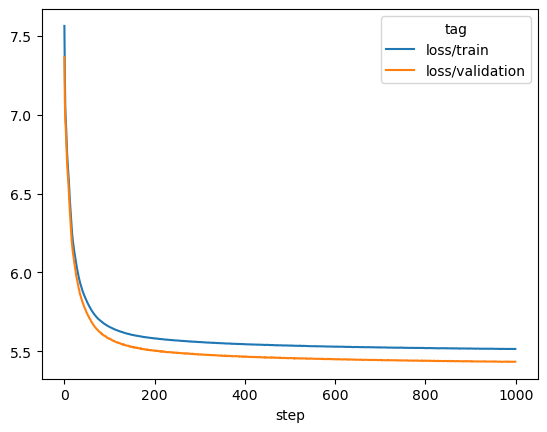

In [35]:
metrics.groupby(["step", "tag"]).mean().unstack()["value"].plot()

## Model Predictions

Now we can use the trained model to do some predictions. 

In [105]:
torch.random.manual_seed(0)
test_dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=5,
    window_size=1,
)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
test_batch = next(iter(test_dataloader))

2024-08-21 12:32:45.832 | INFO     | data:__init__:47 - Creating MovieLensSequenceDataset with validation set: %s
2024-08-21 12:32:45.833 | INFO     | data:_read_data:60 - Reading data from files
2024-08-21 12:32:45.833 | INFO     | data:_read_data:60 - Reading data from files
2024-08-21 12:32:47.698 | INFO     | data:_add_tokens:122 - Adding tokens to data
2024-08-21 12:32:47.735 | INFO     | data:_generate_sequences:132 - Generating sequences
2024-08-21 12:32:48.320 | INFO     | data:__init__:55 - Train data length: 183303
2024-08-21 12:32:48.321 | INFO     | data:__init__:56 - Validation data length: 20393


In [106]:
movie_ids, rating_ids, user_ids, movie_targets, rating_targets = test_batch

In [107]:
movies[movies["movie_id"].isin(movie_ids.numpy().ravel())]

movie_id                                           title  \
122        124  Star Maker, The (Uomo delle stelle, L') (1995)   
287        290                       Once Were Warriors (1994)   
438        442                           Demolition Man (1993)   
527        531                       Secret Garden, The (1993)   
1316      1336                               Body Parts (1991)   
1505      1544           Lost World: Jurassic Park, The (1997)   
1627      1673                            Boogie Nights (1997)   
1878      1947                          West Side Story (1961)   
1884      1953                   French Connection, The (1971)   
1968      2037                               Candleshoe (1977)   
1979      2048               Great Mouse Detective, The (1986)   
2003      2072                              'burbs, The (1989)   
2234      2303                                Nashville (1975)   
2317      2386               Jerry Springer: Ringmaster (1998)   
2381      2450                          Howard the Duck (1986)   
2504      2573                                    Tango (1998)   
2602      2671                             Notting Hill (1999)   
2852      2921                      High Plains Drifter (1972)   
2950      3019                         Drugstore Cowboy (1989)   
3496      3565                       Where the Heart Is (2000)   

                                genres  
122                              Drama  
287                        Crime|Drama  
438                      Action|Sci-Fi  
527                   Children's|Drama  
1316                            Horror  
1505  Action|Adventure|Sci-Fi|Thriller  
1627                             Drama  
1878                   Musical|Romance  
1884       Action|Crime|Drama|Thriller  
1968       Adventure|Children's|Comedy  
1979              Animation|Children's  
2003                            Comedy  
2234                     Drama|Musical  
2317                             Drama  
2381       Adventure|Children's|Sci-Fi  
2504                             Drama  
2602                    Comedy|Romance  
2852                           Western  
2950                       Crime|Drama  
3496                      Comedy|Drama

### Naive Predictions

As a naive prediction, let's take the last token in the model output as the predicted movies i.e. based on the problem framing, we can think of the last token in the output as the next predicted token!

In [127]:
trained_model_state_dict = torch.load("./models/model_1000_epochs_5_256_32_32_4_4.pth")
model_config = get_model_config(config, test_dataset)
trained_model = MovieLensTransformer(model_config)
trained_model.load_state_dict(trained_model_state_dict)


def predict_next_movie(model, movie_ids, user_ids):
    model.eval()
    logits = model(movie_ids=movie_ids, user_ids=user_ids)
    probabilities = F.softmax(logits, dim=-1)
    predicted_movie_ids = torch.argmax(probabilities, dim=-1)
    next_movie_ids = predicted_movie_ids[:, -1]
    print(movie_ids)
    print(predicted_movie_ids)
    print(next_movie_ids)
    return next_movie_ids

/tmp/ipykernel_168230/2424469547.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_state_dict = torch.load("./models/model_1000_epochs_5_256_32_32_4_4.pth")


In [128]:
predict_next_movie(trained_model, movie_ids, user_ids)

tensor([[ 124, 1544, 1673,  531, 2671],
        [1947, 2303, 2450, 3019,  442],
        [3565, 2573,  290, 2921, 2037],
        [2048, 1336, 2386, 1953, 2072]], dtype=torch.int32)
tensor([[ 354, 1227, 1252, 1252, 1252],
        [1947,  497,  497, 2056,  497],
        [2925, 1086,  771,  771,  771],
        [2048, 2572, 2917, 3636, 2917]])
tensor([1252,  497,  771, 2917])


tensor([1252,  497,  771, 2917])

Based on the above, it seems that model has actually learnt some movie tokens i.e. movies that have already been watched by a user show up in the output sequence. It is a good sign. We do not want all the movie ids in the input sequence also in the output sequence in exactly the same sequence. Since, that would mean that the model is overfit!

Let's look at these prediction using our movie posters:

In [129]:
merged = torch.cat([movie_ids, next_movie_ids.unsqueeze(1)], dim=1)
merged

tensor([[ 124, 1544, 1673,  531, 2671, 3030],
        [1947, 2303, 2450, 3019,  442, 2395],
        [3565, 2573,  290, 2921, 2037, 3636],
        [2048, 1336, 2386, 1953, 2072, 1492]], dtype=torch.int32)

In [136]:
rows, columns = merged.shape
movie_image_files = []

token_to_movie = {v: k for k, v in test_dataset.metadata.movie_id_tokens.items()}
for row in range(rows):
    movie_image_files.append(
        [
            f"/mnt/metaverse-nas/movielens/mlp-20m/MLP-20M/{token_to_movie[image_token.item()]}.jpg"
            for image_token in merged[row]
        ]
    )

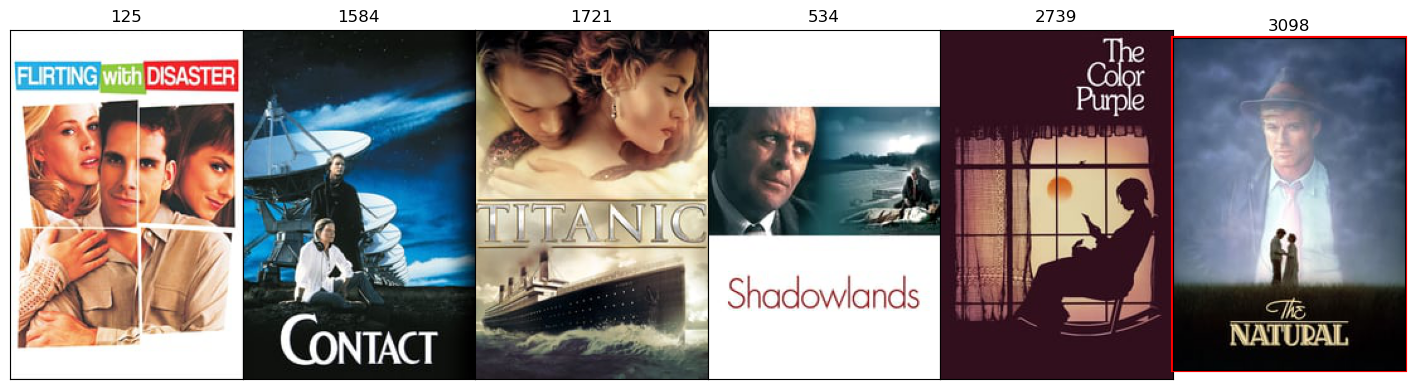

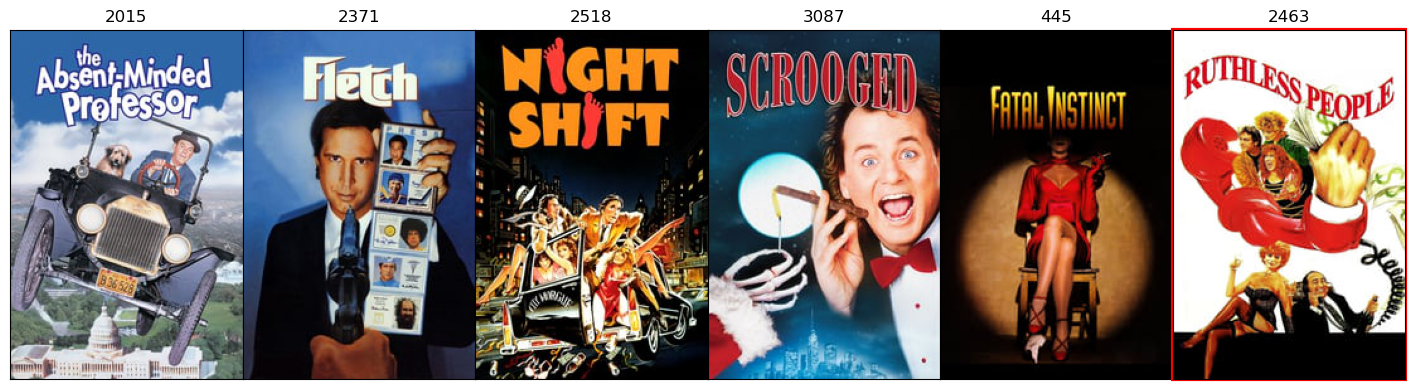

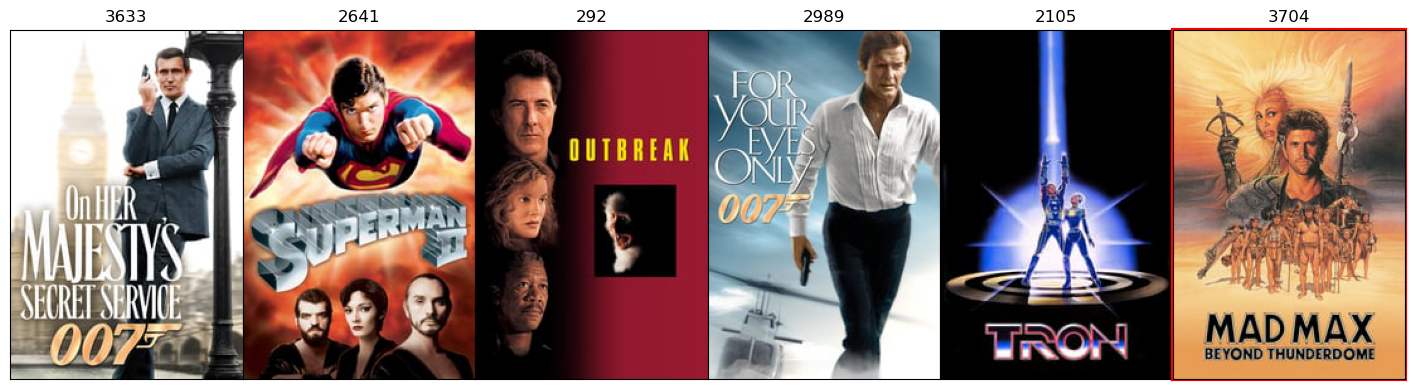

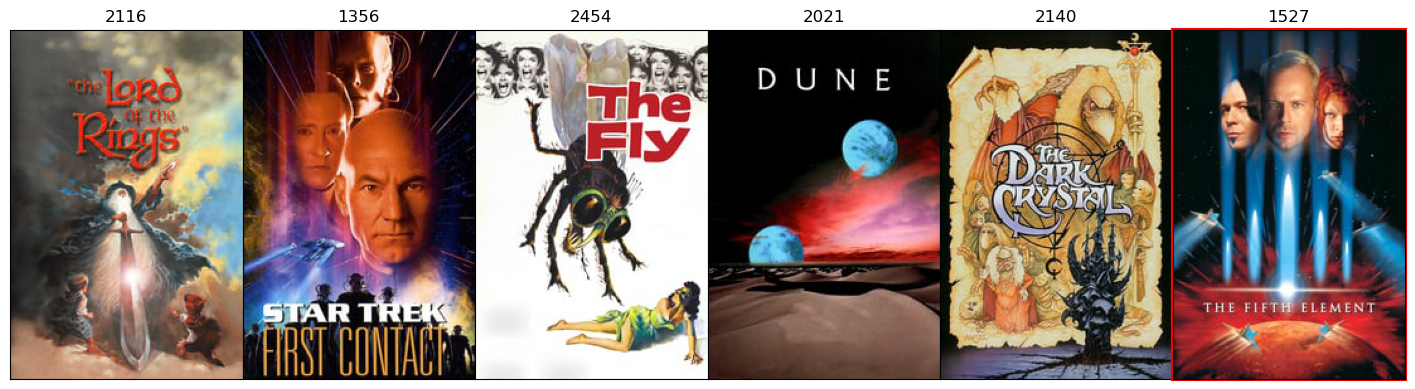

In [143]:
import os

for image_row in movie_image_files:
    fig, axs = plt.subplots(1, columns, figsize=(18, 5))
    for i, (ax, img) in enumerate(zip(axs.flat, image_row)):
        if os.path.exists(img):
            ax.imshow(imread(img))
        if i == columns - 1:
            ax.patch.set_edgecolor("red")
            ax.patch.set_linewidth(3)
        # ax.axis("off")  # Turn off axis
        ax.set_aspect("equal")
        ax.set_title(os.path.basename(img).split(".")[0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Metrics